In [2]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Importando os módulos contendo as funções criadas no projeto

from aux_train import *
from aux_plot import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [3]:
equation = transp_equation

Sim_JS    = simulation(API_Numpy, transp_equation, WENO_JS    , mapping = null_mapping, map_function = None).Sim
Sim_Z     = simulation(API_Numpy, transp_equation, WENO_Z     , mapping = null_mapping, map_function = None).Sim
Sim_Zp    = simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = null_mapping, map_function = None).Sim
Sim_JS_M  = simulation(API_Numpy, transp_equation, WENO_JS    , mapping = post_mapping, map_function = Henrick_mapping).Sim
Sim_Z_M   = simulation(API_Numpy, transp_equation, WENO_Z     , mapping = post_mapping, map_function = Henrick_mapping).Sim
Sim_Zp_M  = simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = post_mapping, map_function = Henrick_mapping).Sim
Sim_JS_MS = simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = Hong_mapping).Sim
Sim_Z_MS  = simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = Hong_mapping).Sim
Sim_Zp_MS = simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = Hong_mapping).Sim
Sim_JS_BI = simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = BI_mapping).Sim
Sim_Z_BI  = simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = BI_mapping).Sim
Sim_Zp_BI = simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = BI_mapping).Sim

Sim_Zm    = simulation(API_Numpy, transp_equation, WENO_Z_pm , mapping =     null_mapping, map_function = None).Sim
Sim_Zm_M  = simulation(API_Numpy, transp_equation, WENO_Z_pm , mapping = post_inv_mapping, map_function = Henrick_mapping).Sim
Sim_Zm_MS = simulation(API_Numpy, transp_equation, WENO_Z_pm , mapping =  pre_inv_mapping, map_function = Hong_mapping).Sim
Sim_Zm_BI = simulation(API_Numpy, transp_equation, WENO_Z_pm , mapping =  pre_inv_mapping, map_function = BI_mapping).Sim

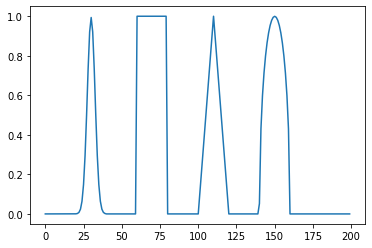

In [4]:
Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [5]:
t_final = 100
n       = 400
CFL     = 0.2
fator   = 10   # Quantas vezes menor é a malha para a solução de referência

BoundaryCondition = FronteiraPeriodica

Δx     = 2/n
u_JS   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS
u_Z    = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z
u_Zp   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+
u_JSM  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (Henrick)
u_ZM   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (Henrick)
u_ZpM  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (Henrick)
u_JSMS = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (Hong)
u_ZMS  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (Hong)
u_ZpMS = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (Hong)
u_JSBI = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (BI)
u_ZBI  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (BI)
u_ZpBI = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (BI)

u_Zm   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-ZM = WENO-Z+
u_ZmM  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-ZM com mapeamento (Henrick)
u_ZmMS = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-ZM com mapeamento (Hong)
u_ZmBI = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-ZM com mapeamento (BI)

n_ref  = n*fator
Δx_ref = 2/n_ref
u_ref  = f_test(tf.range(-1, 1, Δx_ref, dtype=float_pres))[:]
    
try:
    u_JS  = Sim_JS(     u_JS  , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-JS      passou no teste")
except:
    print("WARNING: WENO-JS falhou no teste")
try:
    u_Z   = Sim_Z(      u_Z   , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z       passou no teste")
except:
    print("WARNING: WENO-Z falhou no teste")
try:
    u_Zp  = Sim_Zp(     u_Zp  , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z+      passou no teste")
except:
    print("WARNING: WENO-Z+ falhou no teste")
try:
    u_JSM = Sim_JS_M(   u_JSM , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-JS (M)  passou no teste")
except:
    print("WARNING: WENO-JS (M) falhou no teste")
try:
    u_ZM  = Sim_Z_M(    u_ZM  , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z  (M)  passou no teste")
except:
    print("WARNING: WENO-Z (M) falhou no teste")
try:
    u_ZpM = Sim_Zp_M(   u_ZpM , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z+ (M)  passou no teste")
except:
    print("WARNING: WENO-Z+ (M) falhou no teste")
try:
    u_JSMS = Sim_JS_MS( u_JSMS, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-JS (MS) passou no teste")
except:
    print("WARNING: WENO-JS (MS) falhou no teste")
try:
    u_ZMS  = Sim_Z_MS(  u_ZMS , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z  (MS) passou no teste")
except:
    print("WARNING: WENO-Z (MS) falhou no teste")
try:
    u_ZpMS = Sim_Zp_MS( u_ZpMS, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z+ (MS) passou no teste")
except:
    print("WARNING: WENO-Z+ (MS) falhou no teste")
try:
    u_JSBI = Sim_JS_BI( u_JSBI, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-JS (BI) passou no teste")
except:
    print("WARNING: WENO-JS (BI) falhou no teste")
try:
    u_ZBI  = Sim_Z_BI(  u_ZBI , t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z  (BI) passou no teste")
except:
    print("WARNING: WENO-Z (BI) falhou no teste")
try:
    u_ZpBI = Sim_Zp_BI( u_ZpBI, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-Z+ (BI) passou no teste")
except:
    print("WARNING: WENO-JS (BI) falhou no teste")
try:
    u_Zm = Sim_Zm( u_Zm, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-ZM      passou no teste")
except:
    print("WARNING: WENO-ZM falhou no teste")
try:
    u_ZmM = Sim_Zm_M( u_ZmM, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-ZM (M)  passou no teste")
except:
    print("WARNING: WENO-ZM (M) falhou no teste")
try:
    u_ZmMS = Sim_Zm_MS( u_ZmMS, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-ZM (MS) passou no teste")
except:
    print("WARNING: WENO-ZM (MS) falhou no teste")
try:
    u_ZmBI = Sim_Zm_BI( u_ZmBI, t_final, Δx    , CFL, BoundaryCondition)[:]
    print("WENO-ZM (BI) passou no teste")
except:
    print("WARNING: WENO-ZM (BI) falhou no teste")
# try:
#     u_ref = Sim_Z(u_ref, t_final, Δx_ref, CFL, BoundaryCondition)[:]
#     print("Solução de referência obtida com sucesso")
# except:
#     print("Ocorreu um erro na obtenção da solução de referência")

WENO-JS      passou no teste
WENO-Z       passou no teste
WENO-Z+      passou no teste
WENO-JS (M)  passou no teste
WENO-Z  (M)  passou no teste
WENO-Z+ (M)  passou no teste
WENO-JS (MS) passou no teste
WENO-Z  (MS) passou no teste
WENO-Z+ (MS) passou no teste
WENO-JS (BI) passou no teste
WENO-Z  (BI) passou no teste
WENO-Z+ (BI) passou no teste
WENO-ZM      passou no teste
WENO-ZM (M)  passou no teste
WENO-ZM (MS) passou no teste
WENO-ZM (BI) passou no teste


In [6]:
aux_x     = [  Δx,  Δx,   Δx,    Δx,   Δx,    Δx,     Δx,    Δx,     Δx,     Δx,    Δx,     Δx,   Δx,    Δx,     Δx,     Δx]
aux_y     = [u_JS, u_Z, u_Zp, u_JSM, u_ZM, u_ZpM, u_JSMS, u_ZMS, u_ZpMS, u_JSBI, u_ZBI, u_ZpBI, u_Zm, u_ZmM, u_ZmMS, u_ZmBI]
aux_label = ["WENO-JS"     , "WENO-Z"     , "WENO-Z+"     ,
             "WENO-JS (M)" , "WENO-Z (M)" , "WENO-Z+ (M)" ,
             "WENO-JS (MS)", "WENO-Z (MS)", "WENO-Z+ (MS)",
             "WENO-JS (BI)", "WENO-Z (BI)", "WENO-Z+ (BI)",
             "WENO-ZM"     , "WENO-ZM (M)", "WENO-ZM (MS)",
             "WENO-ZM (BI)"]

x     = tf.range(-1, 1, aux_x[0], dtype=float_pres)
y     = aux_y[0]
label = tf.repeat([aux_label[0]], [len(aux_y[0])])

for i in tf.range(1, len(aux_x)):
    x = tf.concat([x, tf.range(-1, 1, aux_x[i], dtype=float_pres)], axis = 0)
    y = tf.concat([y, aux_y[i]], axis = 0)
    label = tf.concat([label, tf.repeat([aux_label[i]], [len(aux_y[i])])], axis = 0)
    
df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y     ,
        "label" : label
    }
)

In [7]:
fig = ply_exp.line(
    data_frame = df    ,
    x          = x     ,
    y          = y     ,
    color      = label
)
fig.add_trace(
    ply_go.Scatter(
        x    = tf.range(-1, 1, Δx_ref, dtype=float_pres)         ,
        y    = f_test(tf.range(-1, 1, Δx_ref, dtype=float_pres)) , # u_ref, 
        mode = "lines"                                           ,
        line = ply_go.scatter.Line(color="#666666")              ,
        name = "Referência"
    )
)
fig.show()

In [9]:
fig.write_html("htmls/formas_WENO (T=100).html")

In [3]:
Get_JS    = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping = null_mapping, map_function = None)[3]
Get_Z     = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping = null_mapping, map_function = None)[3]
# Get_Zp    = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = null_mapping, map_function = None)[3]
# Get_JS_M  = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping = post_mapping, map_function = Henrick_mapping)[3]
# Get_Z_M   = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping = post_mapping, map_function = Henrick_mapping)[3]
# Get_Zp_M  = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = post_mapping, map_function = Henrick_mapping)[3]
# Get_JS_MS = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = Hong_mapping)[3]
# Get_Z_MS  = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = Hong_mapping)[3]
# Get_Zp_MS = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = Hong_mapping)[3]
Get_JS_BI = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = BI_mapping)[3]
Get_Z_BI  = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = BI_mapping)[3]
# Get_Zp_BI = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = BI_mapping)[3]


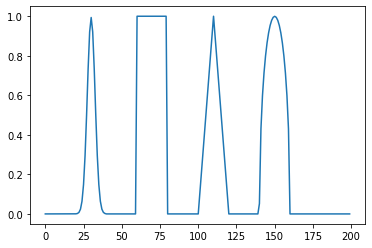

In [4]:
Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [7]:
t_final = 2
n       = 400
CFL     = 0.2
fator   = 6 # Quantas vezes menor é a malha para a solução de referência
    
Δx     = 2/n
u_JS   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS
u_Z    = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z
# u_Zp   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+
# u_JSM  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (Henrick)
# u_ZM   = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (Henrick)
# u_ZpM  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (Henrick)
# u_JSMS = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (Hong)
# u_ZMS  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (Hong)
# u_ZpMS = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (Hong)
u_JSBI = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-JS com mapeamento (BI)
u_ZBI  = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z  com mapeamento (BI)
# u_ZpBI = f_test(tf.range(-1, 1, Δx, dtype=float_pres))[:] # WENO-Z+ com mapeamento (BI)

n_ref  = n*fator
Δx_ref = 2/n_ref
# u_ref  = f_test(tf.range(-1, 1, Δx_ref, dtype=float_pres))
    
u_JS  = Get_JS(     u_JS  , Δx, FronteiraPeriodica)[0]
print("WENO-JS")
u_Z   = Get_Z(      u_Z   , Δx, FronteiraPeriodica)[0]
print("WENO-Z")
# u_Zp  = Get_Zp(     u_Zp  , Δx, FronteiraPeriodica)[0]
# print("WENO-Z+")
# u_JSM = Get_JS_M(   u_JSM , Δx, FronteiraPeriodica)[0]
# print("WENO-JS (M)")
# u_ZM  = Get_Z_M(    u_ZM  , Δx, FronteiraPeriodica)[0]
# print("WENO-Z (M)")
# u_ZpM = Get_Zp_M(   u_ZpM , Δx, FronteiraPeriodica)[0]
# print("WENO-Z+ (M)")
# u_JSMS = Get_JS_MS( u_JSMS, Δx, FronteiraPeriodica)[0]
# print("WENO-JS (MS)")
# u_ZMS  = Get_Z_MS(  u_ZMS , Δx, FronteiraPeriodica)[0]
# print("WENO-Z (MS)")
# u_ZpMS = Get_Zp_MS( u_ZpMS, Δx, FronteiraPeriodica)[0]
# print("WENO-Z+ (MS)")
u_JSBI = Get_JS_BI( u_JSBI, Δx, FronteiraPeriodica)[0]
print("WENO-JS (BI)")
u_ZBI  = Get_Z_BI(  u_ZBI , Δx, FronteiraPeriodica)[0]
print("WENO-Z (BI)")
# u_ZpBI = Get_Zp_BI( u_ZpBI, Δx, FronteiraPeriodica)[0]
# print("WENO-Z+ (BI)")


WENO-JS
WENO-Z
WENO-JS (BI)
WENO-Z (BI)


In [30]:
# aux = [ 35,  85] # Primeira forma: 035-085
# aux = [115, 165] # Segunda  forma: 115-165
# aux = [195, 245] # Terceira forma: 195-245
# aux = [275, 325] # Quarta   forma: 275-325

# print(u_JSBI[aux[0]:aux[1]])
# print(u_ZBI[aux[0]:aux[1]]-u_JSBI[aux[0]:aux[1]])
# print(u_ZBI[aux[0]:aux[1]])

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.12471261  0.06483147  0.05988114]
 [ 0.02935946 -0.01834966 -0.0110098 ]
 [ 0.00566038  0.03396226 -0.03962264]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.        

In [3]:
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_JS)
# WENO_JS_ref       = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z)
# WENO_Z_ref        = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z_plus)
# WENO_Z_plus_ref   = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_JS    , mapping = post_mapping, map_function = Henrick_mapping)
# WENO_JS_M_ref     = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z     , mapping = post_mapping, map_function = Henrick_mapping)
# WENO_Z_M_ref      = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
# Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z_plus, mapping = post_mapping, map_function = Henrick_mapping)
# WENO_Z_plus_M_ref = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)

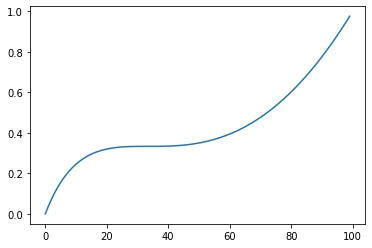

In [4]:
Δx = 0.01

f_test = lambda x: Henrick_function(x, 1/3)
plt.plot(f_test(tf.range(0, 1, Δx, dtype=float_pres)))

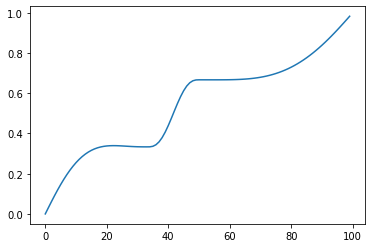

In [4]:
Δx = 0.01

# f_test = lambda x: function_BI(x, 0)
# x = [i for i in map(f_test, tf.range(0, 1, Δx, dtype=float_pres))]
# plt.plot(x)

plt.plot(function_BI(np.arange(0, 1, Δx, dtype=float_pres), 0))

In [3]:
Sim_JS    = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping = null_mapping, map_function = None)[1]
Sim_Z     = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping = null_mapping, map_function = None)[1]
Sim_Zp    = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = null_mapping, map_function = None)[1]
Sim_JS_M  = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping = post_mapping, map_function = Henrick_mapping)[1]
Sim_Z_M   = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping = post_mapping, map_function = Henrick_mapping)[1]
Sim_Zp_M  = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping = post_mapping, map_function = Henrick_mapping)[1]
Sim_JS_MS = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = Hong_mapping)[1]
Sim_Z_MS  = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = Hong_mapping)[1]
Sim_Zp_MS = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = Hong_mapping)[1]
Sim_JS_BI = create_simulation(API_Numpy, transp_equation, WENO_JS    , mapping =  pre_mapping, map_function = BI_mapping)[1]
Sim_Z_BI  = create_simulation(API_Numpy, transp_equation, WENO_Z     , mapping =  pre_mapping, map_function = BI_mapping)[1]
Sim_Zp_BI = create_simulation(API_Numpy, transp_equation, WENO_Z_plus, mapping =  pre_mapping, map_function = BI_mapping)[1]


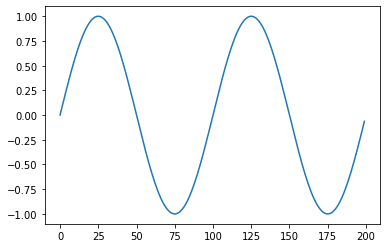

In [4]:
Δx = 0.01

f_test = lambda x: np.sin(2*pi*x) #np.exp(-0.05*(x**2))
plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [ ]:
Δt  = 0.0001

n  = list(range(30, 100+1, 10)) # list(range(40, 40+1, 10))
Δx = n[:]

u_JS  = [] # WENO-JS
u_Z   = [] # WENO-Z
u_Zp  = [] # WENO-Z+
# u_JSM = [] # WENO-JS com mapeamento (Henrick)
# u_ZM  = [] # WENO-Z  com mapeamento (Henrick)
# u_ZpM = [] # WENO-Z+ com mapeamento (Henrick)

n_ref  = []
Δx_ref = []
u_ref  = []

fator = 10 # Quantas vezes menor é a malha para a solução de referência

for k in range(len(n)):
    
    Δx[k] = 2/n[k]
    u_JS.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_Z.append(  f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_Zp.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
#     u_JSM.append(f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
#     u_ZM.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
#     u_ZpM.append(f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    
    n_ref.append(n[k]*fator)
    Δx_ref.append(2/n_ref[k])
    u_ref.append(f_test(tf.range(-1, 1, Δx_ref[k], dtype=float_pres)))
    
for k in tf.range(len(n)):
    for t in tf.range(int(5/(9*Δt))):
        u_JS[k]  =        WENO_JS_ref(u_JS[k], Δt,     Δx[k], FronteiraPeriodica)
        u_Z[k]   =          WENO_Z_ref(u_Z[k], Δt,     Δx[k], FronteiraPeriodica)
        u_Zp[k]  =    WENO_Z_plus_ref(u_Zp[k], Δt,     Δx[k], FronteiraPeriodica)
#         u_JSM[k] =     WENO_JS_M_ref(u_JSM[k], Δt,     Δx[k], FronteiraPeriodica)
#         u_ZM[k]  =       WENO_Z_M_ref(u_ZM[k], Δt,     Δx[k], FronteiraPeriodica)
#         u_ZpM[k] = WENO_Z_plus_M_ref(u_ZpM[k], Δt,     Δx[k], FronteiraPeriodica)
        u_ref[k] =        WENO_Z_ref(u_ref[k], Δt, Δx_ref[k], FronteiraPeriodica)


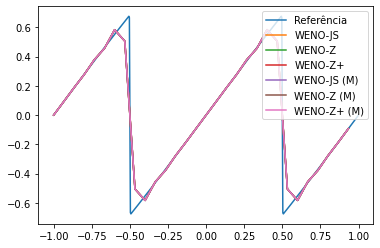

In [61]:
fig, axis = plt.subplots()
axis.plot(tf.range(-1, 1, Δx_ref[0], dtype=float_pres), u_ref[0], label="Referência")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_JS[0], label="WENO-JS")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),   u_Z[0], label="WENO-Z")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_Zp[0], label="WENO-Z+")
# axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres), u_JSM[0], label="WENO-JS (M)")
# axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_ZM[0], label="WENO-Z (M)")
# axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres), u_ZpM[0], label="WENO-Z+ (M)")
axis.legend()

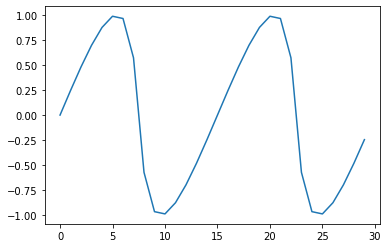

In [41]:
plt.plot(tf.gather(u_ref[0], tf.range(0, n[0])*fator))

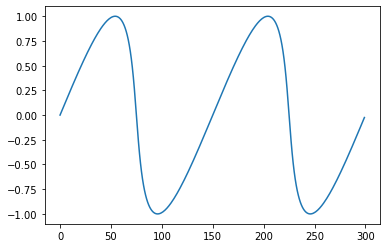

In [42]:
plt.plot(u_ref[0])

In [39]:
error = []

for k in tf.range(len(n)):
    
    aux = tf.gather(u_ref[k], tf.range(0, n[k])*fator)
    error.append(np.mean(np.abs(u[k]-aux)))

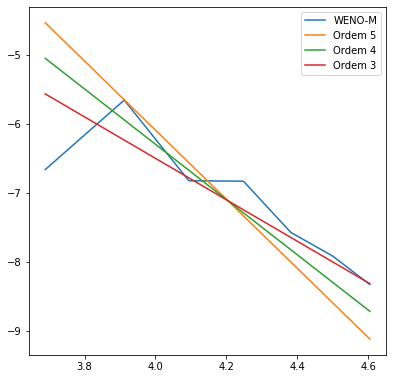

In [27]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(n),np.log(error),label='WENO-M')
plt.plot(np.log(n),-5*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 5')
plt.plot(np.log(n),-4*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 4')
plt.plot(np.log(n),-3*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 3')
plt.legend()

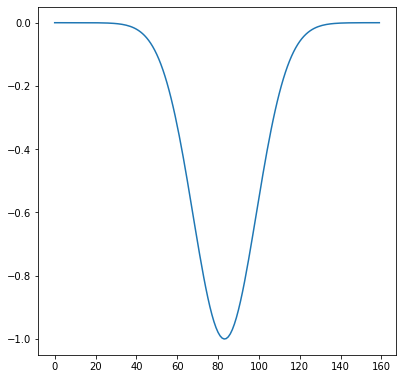

In [41]:
#plt.plot(net_u[0,0])
plt.figure(figsize=(6.4,6.4))
plt.plot(ref_u[0,0])
plt.savefig('imagens/ordem conv ds funcao.png')

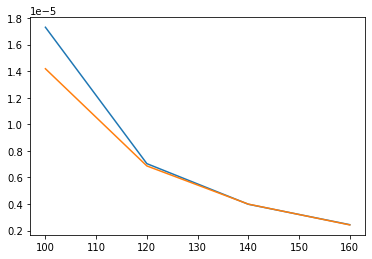

In [42]:
plt.plot(sizes,error1)
plt.plot(sizes,error2)

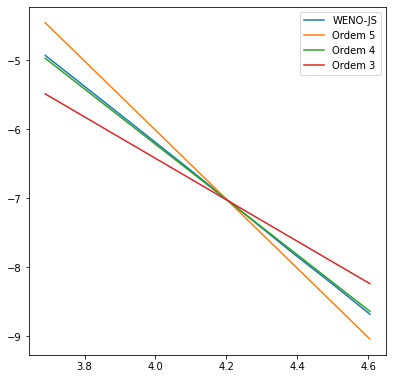

In [95]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(n),np.log(error),label='WENO-JS')
plt.plot(np.log(n),-5*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 5')
plt.plot(np.log(n),-4*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 4')
plt.plot(np.log(n),-3*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 3')
plt.legend()

In [ ]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [16]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [17]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=WENO_network(u1, Δx1)

print(u1.shape)

(1, 200)


In [18]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=WENO_network(u2, Δx2)

print(u2.shape)

(1, 400)


In [19]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - du1))/np.sum(abs(y2 - du2)))

0.49998867338114705
